In [1]:
import os
import math
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.colors
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import datetime

In [2]:
Data_Root = '/home/haopeng/Data/Promotion/'

In [3]:
CIs = {'90': 1.645, '95': 1.96, '99': 2.576}

In [4]:
labels = ['Male', 'Female']

In [5]:
colors = sns.color_palette()[:len(labels)]

In [6]:
reg_data = pd.read_csv(Data_Root+"reg_data_drop_missing.csv", header=0, dtype={'matched_tid': str, 'matched_tid_retweet': str, 'matched_tid_original': str})


In [7]:
len(reg_data)

3073001

In [8]:
reg_data.head(n=3)

,doi,author_name,authorship_seq,authorship_pos,author_id,affiliation_ids,self_promotion_original,gender,num_authors,author_rank,...,author_self_promotion_rate,matched_tid_original,matched_tid_retweet,matched_tid,total_num_tweets,self_promo_position,self_promo_position_frac,matched_tid_follower_cn,self_promo_time,self_promotion_def
0,10.1109/tmag.2017.2750019,Daniel S. Gazzana,1,first_position,2040190777,130442723,False,Male,6,16859,...,0.0,NaN,NaN,NaN,0,-1,-1.0,-1,-1.0,False
1,10.1109/tmag.2017.2750019,Arturo S. Bretas,4,middle_position,2115308334,130442723,False,Male,6,15192,...,0.0,NaN,NaN,NaN,0,-1,-1.0,-1,-1.0,False
2,10.1109/tmag.2017.2750019,Roberto C. Leborgne,3,middle_position,2145772920,130442723,False,Male,6,16228,...,0.5,NaN,NaN,NaN,0,-1,-1.0,-1,-1.0,False


In [9]:
np.sum(reg_data.num_authors == 1)
# np.sum(reg_data.authorship_pos == 'solo_author')

34229

In [10]:
reg_data.gender.value_counts()

Male       1519585
Female      860513
Unknown     516230
Unisex      176673
Name: gender, dtype: int64

In [11]:
reg_data.gender.value_counts()/len(reg_data)

Male       0.494495
Female     0.280024
Unknown    0.167989
Unisex     0.057492
Name: gender, dtype: float64

### Exclude unisex and unknown

In [12]:
reg_data = reg_data.loc[reg_data['gender'].isin(['Female', 'Male'])]
reg_data.index = range(len(reg_data))

In [13]:
len(reg_data)

2380098

### Exclude unknown affiliation locations

In [14]:
len(reg_data.loc[reg_data.affiliation_ids.isnull()])

0

In [15]:
len(reg_data.loc[reg_data.affiliation_cate=='unknown'])

4679

In [16]:
reg_data = reg_data.loc[reg_data.affiliation_cate != 'unknown']
reg_data.index = range(len(reg_data))

In [17]:
len(reg_data)

2375419

In [18]:
len(set(reg_data.doi))

539345

### Author-level: histogram of self-promotion rate per author

In [80]:
len(set(reg_data.author_id))

1335603

In [81]:
# gender distribution of all authors
for gender, sub_df in reg_data.groupby('gender'):
    n = len(set(sub_df['author_id']))
    print(gender, n/len(set(reg_data.author_id)))

Female 0.41343423157929415
Male 0.5955055506763611


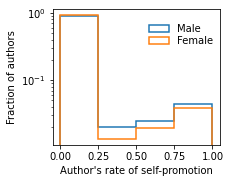

In [21]:
fig, ax = plt.subplots(figsize = (3, 2.5))

for gender, color in zip(labels, colors):
    sub_df = reg_data.loc[reg_data['gender'] == gender, ['author_id', 'author_self_promotion_rate']]
    sub_df = sub_df.drop_duplicates()
    n = len(sub_df)
    ax.hist(sub_df['author_self_promotion_rate'].tolist(), bins = 4, alpha=1, linewidth=1.5, \
            color=color, label=gender, histtype='step', weights=np.ones(n)/n)
# ax.set_ylabel('Number of authors')
ax.set_ylabel('Fraction of authors')
ax.set_xlabel("Author's rate of self-promotion")
ax.set_yscale('log')
legend = ax.legend(loc=[0.55, 0.7], numpoints=2, labelspacing = 0.15, shadow=False, frameon = False)
plt.show()
fig.savefig('gender_rate_hist_all_authors.pdf', bbox_inches='tight', pad_inches=0.02)

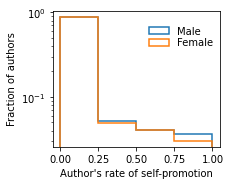

In [22]:
fig, ax = plt.subplots(figsize = (3, 2.5))

for gender, color in zip(labels, colors):
    mask = (reg_data['gender'] == gender) & (reg_data['author_num_papers_in_data'] >= 5)
    sub_df = reg_data.loc[mask, ['author_id', 'author_self_promotion_rate']]
    sub_df = sub_df.drop_duplicates()
    n = len(sub_df)
    ax.hist(sub_df['author_self_promotion_rate'].tolist(), bins = 4, alpha=1, linewidth=1.5, \
            color=color, label=gender, histtype='step', weights=np.ones(n)/n)
# ax.set_ylabel('Number of authors')
ax.set_ylabel('Fraction of authors')
ax.set_xlabel("Author's rate of self-promotion")
ax.set_yscale('log')
legend = ax.legend(loc=[0.55, 0.7], numpoints=2, labelspacing = 0.15, shadow=False, frameon = False)
plt.show()
fig.savefig('gender_rate_hist_authors_5.pdf', bbox_inches='tight', pad_inches=0.02)

### (paper, author) level

In [78]:
reg_data.gender.value_counts()/len(reg_data)

Male      0.638456
Female    0.361544
Name: gender, dtype: float64

In [23]:
np.mean(reg_data.self_promotion)

0.0730793177961446

In [24]:
for gender, group in reg_data.groupby('gender'):
    print(gender, np.mean(group.self_promotion))

Female 0.06389006298183901
Male 0.07828300145061322


In [25]:
for gender, group in reg_data.groupby('gender'):
    print(gender, np.mean(group.self_promotion_original))

Female 0.04219631843263831
Male 0.053296188843465646


In [26]:
for gender, group in reg_data.groupby('gender'):
    print(gender, np.mean(group.self_promotion_retweet))

Female 0.034889773048803065
Male 0.04243439272055915


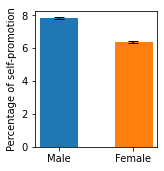

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2.2, 2.5))

s = 3 # markersize
lw = 1.5 # linewidth
xpos = [0, 1]

ys = [np.mean(reg_data.loc[reg_data.gender==gen]['self_promotion']) * 100 for gen in labels]
stds = [np.std(reg_data.loc[reg_data.gender==gen]['self_promotion']) * 100 for gen in labels]
lilen = [len(reg_data.loc[reg_data.gender==gen]) for gen in labels]

barlist = ax.bar(xpos, ys, yerr = CIs['95']*(stds/np.sqrt(lilen)), width = 0.5, alpha = 1.0, capsize = 5)
barlist[0].set_color(colors[0])
barlist[1].set_color(colors[1])

ax.set_ylabel('Percentage of self-promotion')
ax.set_xticks(xpos)
ax.set_xticklabels(labels)
ax.yaxis.grid(False)
# ax.ticklabel_format(axis='y', style='sci', scilimits=(2, 2))
# ax.yaxis.major.formatter._useMathText = True
    
plt.show()
fig.savefig('./perc_promo_gender.pdf', bbox_inches='tight', pad_inches=0.02)

Author position

In [19]:
name_pos = {'first_position': 'First Position', 'middle_position': 'Middle Position', 'last_position': 'Last Position'}

In [20]:
means = [[], []]
confs = [[], []]
aut_pos = []
for pos, subgp in reg_data.groupby('authorship_pos'):
    if pos != 'solo_author':
        print(pos)
        aut_pos.append(pos)
        for i, gen in enumerate(labels):
            gp = subgp.loc[subgp.gender==gen]
            means[i].append(np.mean(gp['self_promotion']) * 100)
            sigma = np.std(gp['self_promotion']) * 100
            confs[i].append(CIs['95']*(sigma/np.sqrt(len(gp))))

first_position
last_position
middle_position


In [21]:
means

[[12.974235793491495, 10.751648851489652, 5.766091692433255],
 [10.940853346959631, 9.596752957841117, 4.279071205091131]]

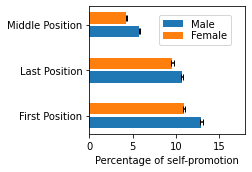

In [30]:
step = 4
ys_1 = 0.9 + np.arange(3) * step
ys_2 = 2.1 + np.arange(3) * step
y_pos = 1.5 + np.arange(3) * step

fig, ax = plt.subplots(figsize = (3.6, 2.5))

ax.barh(ys_1, width = means[0], height=1, xerr = confs[0], alpha = 1.0, capsize = 3, color=colors[0], label='Male')
ax.barh(ys_2, width = means[1], height=1, xerr = confs[1], alpha = 1.0, capsize = 3, color=colors[1], label='Female')

legend = ax.legend(loc=[0.45, 0.7], numpoints=1, labelspacing = 0.15, shadow=False, frameon = True)
ax.set_yticks(y_pos)
ax.set_yticklabels([name_pos[pos] for pos in aut_pos], rotation=0, ha='right')
ax.set_xlabel('Percentage of self-promotion')
ax.set_xlim([0, 18])
plt.tight_layout()
plt.show()
fig.savefig('./perc_promo_gender_pos.pdf', bbox_inches='tight', pad_inches=0.02)


Discipline

In [22]:
name_map = {'Social Sciences': 'Social_Sciences',
            'Life Sciences': 'Life_Sciences',
            'Health Sciences': 'Health_Sciences',
            'Physical Sciences': 'Physical_Sciences'}

In [23]:
len(reg_data.loc[(reg_data['Social_Sciences'] == 1) & (reg_data['Life_Sciences'] == 1)])

17473

In [24]:
for disc in name_map.values():
    sub_df = reg_data.loc[reg_data[disc] == 1]
    print(disc, np.mean(sub_df.self_promotion))

Social_Sciences 0.1347182140945255
Life_Sciences 0.06901976773613025
Health_Sciences 0.06328743624157933
Physical_Sciences 0.05364903193981995


In [25]:
means = [[], []]
confs = [[], []]
for disc in name_map:
    print(disc)
    subgp = reg_data.loc[reg_data[name_map[disc]] == 1]
    for i, gen in enumerate(labels):
        gp = subgp.loc[subgp.gender==gen]
        means[i].append(np.mean(gp['self_promotion']) * 100)
        sigma = np.std(gp['self_promotion']) * 100
        confs[i].append(CIs['95']*(sigma/np.sqrt(len(gp))))

Social Sciences
Life Sciences
Health Sciences
Physical Sciences


In [26]:
means

[[14.186851211072666, 7.922746860493074, 6.814878994939251, 5.474269320423167],
 [12.599704982517482, 5.317751912395769, 5.616804561040249, 5.063728667098726]]

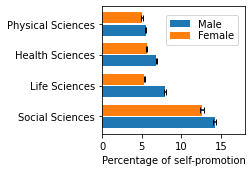

In [35]:
step = 2.5
ys_1 = 1 + np.arange(4) * step
ys_2 = 2 + np.arange(4) * step
y_pos = 1.5 + np.arange(4) * step

fig, ax = plt.subplots(figsize = (3.6, 2.5))

#ax.errorbar(means[0], ys_1, xerr=confs[0], color=colors[0], alpha=1, fmt='o', markersize=3, linewidth=2, label='Male')
#ax.errorbar(means[1], ys_2, xerr=confs[1], color=colors[1], alpha=1, fmt='o', markersize=3, linewidth=3, label='Female')
ax.barh(ys_1, width = means[0], height=0.9, xerr = confs[0], alpha = 1.0, capsize = 3, color=colors[0], label='Male')
ax.barh(ys_2, width = means[1], height=0.9, xerr = confs[1], alpha = 1.0, capsize = 3, color=colors[1], label='Female')

legend = ax.legend(loc=[0.45, 0.7], numpoints=1, labelspacing = 0.15, shadow=False, frameon = True)
ax.set_yticks(y_pos)
ax.set_yticklabels([disc for disc in name_map], rotation=0, ha='right')
ax.set_xlabel('Percentage of self-promotion')
ax.set_xlim([0, 18])
plt.tight_layout()
plt.show()
fig.savefig('./perc_promo_gender_disc.pdf', bbox_inches='tight', pad_inches=0.02)

By journal impact

In [36]:
gender_jif_rate = {'Male': {}, 'Female': {}}

for gender in labels:
    tem = reg_data.loc[reg_data.gender==gender, ['journal_impact', 'self_promotion']]
    tem = tem.dropna()
    tem['jif_bin'] = tem['journal_impact'].apply(lambda x: int(x//5))
    for jif, sub_df in tem.groupby('jif_bin'):
        mu = np.mean(sub_df['self_promotion'])
        std = np.std(sub_df['self_promotion'])
        n = len(sub_df)
        gender_jif_rate[gender][jif] = (mu, std, n)

In [7]:
# gender_jif_rate

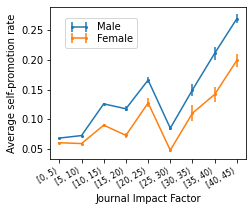

In [37]:
nrows = 1
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3.5, 2.8))

for i, gender, color in zip(range(len(labels)), labels, colors):
    xs = list(range(9))
    ys = []
    confs = []
    for j in xs:
        mu, std, n = gender_jif_rate[gender][j]
        ys.append(mu)
        confs.append(CIs['95'] * std / np.sqrt(n))
    ax.errorbar(xs, ys, yerr=confs, color=color, alpha=1, fmt='-o', markersize=2, linewidth=1.5, label=gender)
    
# ax.legend(bbox_to_anchor=(1, -0.03), loc='lower left', labelspacing = 1.05, frameon = True)
legend = ax.legend(bbox_to_anchor=(0.05, 0.7), loc='lower left', numpoints=2, labelspacing = 0.15, shadow=False, frameon = True, markerscale = 1)
# ax.margins(0,0)
# ax.set_yticks([0.2, 0.4, 0.6, 0.8])
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
ax.set_xticklabels(['[0, 5)', '[5, 10)', '[10, 15)', '[15, 20)', '[20, 25)', '[25, 30)', '[30, 35)', '[35, 40)', \
                    '[40, 45)'])
for tick in ax.get_xticklabels():
    tick.set_ha('right')
    tick.set_fontsize(8)
    tick.set_rotation(30)
ax.set_xlabel('Journal Impact Factor')
ax.set_ylabel('Average self-promotion rate')

# plt.tight_layout()
plt.show()
fig.savefig('./gender_jif_raw.pdf', bbox_inches='tight', pad_inches=0.01)

By affiliation rank

In [38]:
gender_affi_rate = {'Male': {}, 'Female': {}}

for gender in labels:
    tem = reg_data.loc[reg_data.gender==gender, ['affiliation_rank_cate', 'self_promotion']]
    tem = tem.dropna()
    # tem['affi_bin'] = tem['affiliation_rank'].apply(lambda x: int(x//2000))
    for affi, sub_df in tem.groupby('affiliation_rank_cate'):
        mu = np.mean(sub_df['self_promotion'])
        std = np.std(sub_df['self_promotion'])
        n = len(sub_df)
        gender_affi_rate[gender][affi] = (mu, std, n)

In [36]:
# gender_affi_rate

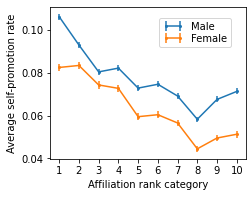

In [39]:
nrows = 1
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3.5, 2.8))

xs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

for i, gender, color in zip(range(len(labels)), labels, colors):
    ys = []
    confs = []
    for j in xs:
        mu, std, n = gender_affi_rate[gender][j]
        ys.append(mu)
        confs.append(CIs['95'] * std / np.sqrt(n))
    ax.errorbar(xs, ys, yerr=confs, color=color, alpha=1, fmt='-o', markersize=2, linewidth=1.5, label=gender)
    
# ax.legend(bbox_to_anchor=(1, -0.03), loc='lower left', labelspacing = 1.05, frameon = True)
legend = ax.legend(bbox_to_anchor=(0.53, 0.7), loc='lower left', numpoints=2, labelspacing = 0.15, shadow=False, frameon = True, markerscale = 1)
# ax.margins(0,0)
# ax.set_yticks([0.2, 0.4, 0.6, 0.8])
ax.set_xticks(xs)
ax.set_xticklabels(list(range(1, 11)))
# for tick in ax.get_xticklabels():
#     tick.set_ha('right')
#     tick.set_fontsize(8)
#     tick.set_rotation(30)
ax.set_xlabel('Affiliation rank category')
ax.set_ylabel('Average self-promotion rate')

# plt.tight_layout()
plt.show()
fig.savefig('./gender_affi_raw.pdf', bbox_inches='tight', pad_inches=0.01)


By previous num. publications

In [40]:
gender_pub_rate = {'Male': {}, 'Female': {}}

for gender in labels:
    tem = reg_data.loc[reg_data.gender==gender, ['author_pub_count_cate', 'self_promotion']]
    tem = tem.dropna()
    # tem['pub_bin'] = tem['author_pub_count'].apply(lambda x: int(x//10))
    for pub, sub_df in tem.groupby('author_pub_count_cate'):
        mu = np.mean(sub_df['self_promotion'])
        std = np.std(sub_df['self_promotion'])
        n = len(sub_df)
        gender_pub_rate[gender][pub] = (mu, std, n)

In [39]:
# gender_pub_rate

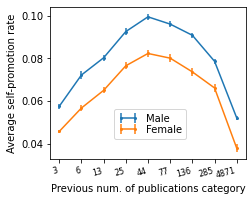

In [41]:
nrows = 1
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3.5, 2.8))

# xs = np.arange(0, 101, 10)
xs = [0, 1, 2, 3, 4, 5, 6, 7, 8]

for i, gender, color in zip(range(len(labels)), labels, colors):
    ys = []
    confs = []
    for j in xs:
        mu, std, n = gender_pub_rate[gender][j]
        ys.append(mu)
        confs.append(CIs['95'] * std / np.sqrt(n))
    ax.errorbar(xs, ys, yerr=confs, color=color, alpha=1, fmt='-o', markersize=2, linewidth=1.5, label=gender)
    
# ax.legend(bbox_to_anchor=(1, -0.03), loc='lower left', labelspacing = 1.05, frameon = True)
legend = ax.legend(bbox_to_anchor=(0.3, 0.1), loc='lower left', numpoints=2, labelspacing = 0.15, shadow=False, frameon = True, markerscale = 1)
ax.set_xticks(xs)
ax.set_xticklabels([3, 6, 13, 25, 44, 77, 136, 285, 4871])
for tick in ax.get_xticklabels():
    tick.set_ha('right')
    tick.set_fontsize(8)
    tick.set_rotation(15)
ax.set_xlabel('Previous num. of publications category')
ax.set_ylabel('Average self-promotion rate')

# plt.tight_layout()
plt.show()
fig.savefig('./gender_pub_raw.pdf', bbox_inches='tight', pad_inches=0.01)


By number of authors

In [42]:
gender_aut_rate = {'Male': {}, 'Female': {}}

for gender in labels:
    tem = reg_data.loc[reg_data.gender==gender, ['num_authors', 'self_promotion']]
    tem = tem.dropna()
    for num, sub_df in tem.groupby('num_authors'):
        mu = np.mean(sub_df['self_promotion'])
        std = np.std(sub_df['self_promotion'])
        n = len(sub_df)
        gender_aut_rate[gender][num] = (mu, std, n)

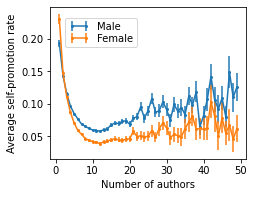

In [43]:
nrows = 1
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3.5, 2.8))

for i, gender, color in zip(range(len(labels)), labels, colors):
    xs = list(range(1, 50))
    ys = []
    confs = []
    for j in xs:
        mu, std, n = gender_aut_rate[gender][j]
        ys.append(mu)
        confs.append(CIs['95'] * std / np.sqrt(n))
    ax.errorbar(xs, ys, yerr=confs, color=color, alpha=1, fmt='-o', markersize=2, linewidth=1.5, label=gender)
    
# ax.legend(bbox_to_anchor=(1, -0.03), loc='lower left', labelspacing = 1.05, frameon = True)
legend = ax.legend(bbox_to_anchor=(0.05, 0.7), loc='lower left', numpoints=2, labelspacing = 0.15, shadow=False, frameon = True, markerscale = 1)
# ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
ax.set_xlabel('Number of authors')
ax.set_ylabel('Average self-promotion rate')

# plt.tight_layout()
plt.show()
fig.savefig('./gender_num_aut_raw.pdf', bbox_inches='tight', pad_inches=0.01)

### Paper-level

In [45]:
# original and retweets
tid_name = {}

with open(Data_Root+'tweets_v2.json', 'r') as ifile:
    for line in ifile:
        line = json.loads(line)
        tid = line['id_str']
        tid_name[tid] = line['user']['name']
        
with open(Data_Root+'tweets_v2_non_full_text.json', 'r') as ifile:
    for line in ifile:
        line = json.loads(line)
        tid = line['id_str']
        tid_name[tid] = line['user']['name']

In [46]:
len(tid_name)

77497304

In [47]:
dois = set(reg_data.doi)

doi_tids = {}
with open(Data_Root+'papers_2018.json', 'r') as ifile:
    for line in ifile:
        res = json.loads(line)
        if res['doi'] in dois:
            doi_tids[res['doi']] = [tweet['tweet_id'] for tweet in res['data']['tweets'] if tweet['tweet_id'] in tid_name]
del dois

In [48]:
len(doi_tids)

539345

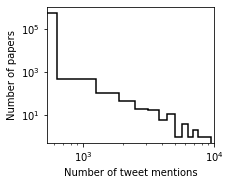

In [49]:
fig, ax = plt.subplots(figsize = (3, 2.5))

ax.hist([len(doi_tids[doi]) for doi in doi_tids], bins = 30, color='k', alpha=1, linewidth=1.5, histtype='step')
ax.set_ylabel('Number of papers')
ax.set_xlabel('Number of tweet mentions')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(right=1e4)
# legend = ax.legend(loc=[0.55, 0.7], numpoints=2, labelspacing = 0.15, shadow=False, frameon = False)
plt.show()
fig.savefig('./paper_tweets_hist.pdf', bbox_inches='tight', pad_inches=0.02)

Popularity

In [82]:
doi_frac_self_promo = []
for doi, sub_df in reg_data.groupby('doi'):
    total = len(doi_tids[doi])
    if total > 0:
        promo_users = set([tid_name[str(tid)] for tid in sub_df.loc[sub_df.self_promotion == True]['matched_tid']])
        num_self_promo = 0
        for tid in doi_tids[doi]:
            if tid_name[tid] in promo_users:
                num_self_promo += 1
        doi_frac_self_promo.append((doi, total, num_self_promo))

In [84]:
len(doi_frac_self_promo)

443070

In [87]:
np.mean([num_self_promo/total for doi, total, num_self_promo in doi_frac_self_promo if total > 0])

0.05859992385390095

In [88]:
for i in range(0, 101, 10):
    tem = []
    for doi, total, num_self_promo in doi_frac_self_promo:
        if total > i and total <= (i+10):
            tem.append(num_self_promo/total)
    print("%d < x <= %d"%(i, i+10), np.mean(tem), np.median(tem))

0 < x <= 10 0.05772640512807563 0.0
10 < x <= 20 0.07032970279079655 0.0
20 < x <= 30 0.066080408242367 0.038461538461538464
30 < x <= 40 0.06059653906118459 0.030303030303030304
40 < x <= 50 0.05574799518367108 0.023809523809523808
50 < x <= 60 0.05473728407608104 0.034482758620689655
60 < x <= 70 0.051349448980181234 0.030303030303030304
70 < x <= 80 0.048113571664359187 0.02702702702702703
80 < x <= 90 0.04652797232766643 0.024096385542168676
90 < x <= 100 0.04647687199405394 0.02197802197802198
100 < x <= 110 0.044037147547581 0.019801980198019802


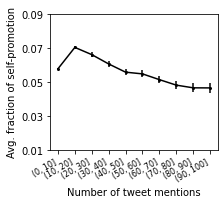

In [89]:
nrows = 1
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3, 2.5))


xs, ys, confs = [], [], []

step = 10
for i in range(0, 91, step):
    xs.append(i)
    tem = []
    for doi, total, num_self_promo in doi_frac_self_promo:
        if total > i and total <= (i+step):
            tem.append(num_self_promo/total)
    ys.append(np.mean(tem))
    confs.append(CIs['95'] * np.std(tem) / np.sqrt(len(tem)))
                    
ax.errorbar(xs, ys, yerr=confs, color='k', fmt='-o', markersize=2, linewidth=1.5)
ax.set_yticks([0.01, 0.03, 0.05, 0.07, 0.09])
ax.set_xticks(xs)
ax.set_xticklabels(['(0, 10]', '(10, 20]', '(20, 30]', '(30, 40]', '(40, 50]', '(50, 60]', '(60, 70]', '(70, 80]', '(80, 90]', '(90, 100]'])
for tick in ax.get_xticklabels():
    tick.set_ha('right')
    tick.set_fontsize(8)
    tick.set_rotation(30)
ax.set_xlabel('Number of tweet mentions')
ax.set_ylabel('Avg. fraction of self-promotion')

# plt.tight_layout()
plt.show()
fig.savefig('./avg_perc_promo_paper_tweets.pdf', bbox_inches='tight', pad_inches=0.01)


Discipline

In [90]:
name_map = {'Social Sciences': 'Social_Sciences',
            'Life Sciences': 'Life_Sciences',
            'Health Sciences': 'Health_Sciences',
            'Physical Sciences': 'Physical_Sciences'}

In [91]:
xs, ys, confs = [], [], []
for disc in name_map:
    tem = []
    dois_ = set(reg_data.loc[reg_data[name_map[disc]] == 1]['doi'])
    for doi, total, num_self_promo in doi_frac_self_promo:
        if doi in dois_:
            tem.append(num_self_promo/total)
    xs.append(np.mean(tem))
    ys.append(disc)
    confs.append(CIs['95'] * np.std(tem) / np.sqrt(len(tem)))

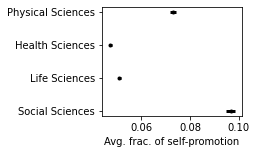

In [92]:
nrows = 1
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2.5, 2))
ax.errorbar(xs, ys, xerr=confs, color='k', alpha=1, fmt='o', markersize=3, linewidth=3)
ax.set_xlabel('Avg. frac. of self-promotion')
plt.show()
fig.savefig('./avg_perc_promo_paper_disc.pdf', bbox_inches='tight', pad_inches=0.01)